In [1]:
# Import all libraries
import tensorflow as tf
from keras.models import Sequential
from keras.layers.core import Dense, Dropout, Activation, Flatten
from keras.layers.convolutional import Conv2D
from keras.optimizers import SGD,RMSprop,Adam
from keras.utils import np_utils
from keras.models import model_from_json
from keras.callbacks import ReduceLROnPlateau, ModelCheckpoint, EarlyStopping
import numpy as np
import matplotlib.pyplot as plt
import matplotlib
import os
os.environ['TF_CPP_MIN_LOG_LEVEL'] = '2' # Disable warning message of tensorflow
import cv2
from numpy import *
from sklearn.utils import shuffle
from sklearn.model_selection import train_test_split
from sklearn.metrics import classification_report,confusion_matrix
from sklearn.metrics import mean_squared_error, mean_absolute_error
from skimage.measure import compare_ssim
from skimage.util import view_as_windows
from skimage import util
import math
from PIL import Image

Using TensorFlow backend.


In [2]:
# Load model and weights
json_file = open('model.json', 'r')
loaded_model_json = json_file.read()
json_file.close()
loaded_model = model_from_json(loaded_model_json)

# Load weights into new model
loaded_model.load_weights("weights.best.h5")
# loaded_model.load_weights("model.h5")
print("Loaded model from disk")

Loaded model from disk


(1024, 1024)


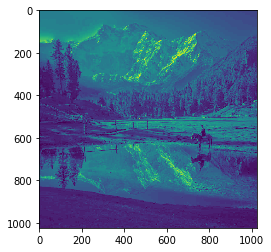

In [3]:
img = cv2.imread('./Input/0002.jpg',0)
plt.imshow(img, cmap='gray')
print(img.shape)

In [9]:
window_shape = (32, 32)
patches = view_as_windows(img, window_shape, step=16)

patches_row = 63
patches_col = 63
predicted = []
for i in range(0,patches_row):   
    for j in range(0,patches_col):
        predicted.append(loaded_model.predict(patches[i,j].reshape(1,32,32,1)))


predicted = (np.array(predicted)).astype('int')
predicted = predicted.reshape(63,63,32,32)
print(predicted.shape)
# plt.imshow(predicted[0,1])
# plt.figure()
# plt.imshow(predicted[0,2])
# print(predicted[0,2].shape)

/share/pkg/python/3.6.2/install/lib/python3.6/site-packages/skimage/util/shape.py:255: FutureWarning: Using a non-tuple sequence for multidimensional indexing is deprecated; use `arr[tuple(seq)]` instead of `arr[seq]`. In the future this will be interpreted as an array index, `arr[np.array(seq)]`, which will result either in an error or a different result.
  indexing_strides = arr_in[slices].strides


(63, 63, 32, 32)


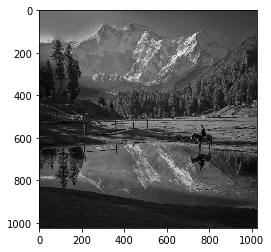

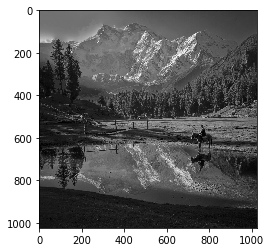

In [12]:
recon = np.zeros([1024,1024])
for i in range(0,patches_row):   
    for j in range(0,patches_col):
        if i%2==0 and j%2==0:
            recon[i*16:(i*16)+32,j*16:(j*16)+32] = np.array(predicted[i,j])
            
for i in range(0,patches_row):   
    for j in range(0,patches_col):
        if i%2!=0 and j%2!=0:
            recon[(i*16):(i*16)+32,(j*16):(j*16)+32] = (recon[(i*16):(i*16)+32,(j*16):(j*16)+32] + np.array(predicted[i,j]))/2

plt.imshow(recon, cmap='gray')
cv2.imwrite('./recon.png', recon)
plt.figure()
plt.imshow(cv2.imread('./Label/0002.png',0), cmap='gray')

In [13]:
# Compute PSNR
Y_test_img = np.array(cv2.imread('./Label/0002.png',0))
Y_test_img = Y_test_img.astype('int')
X_test_img = img
X_test_img = X_test_img.astype('int')
recon = recon.astype('int')

def psnr(img1, img2):
    mse = np.mean((img1 - img2)**2)
    if mse == 0:
        return 100
    PIXEL_MAX = 255.0
    return 20 * math.log10(PIXEL_MAX / math.sqrt(mse))

psnr_X_test = psnr(Y_test_img, X_test_img)
print('\nPSNR (Y, X): ', psnr_X_test)
psnr_predict = psnr(Y_test_img, recon)
print('PSNR (Y, Recon): ', psnr_predict)


PSNR (Y, X):  28.96854755827938
PSNR (Y, Recon):  29.493908322578072


In [14]:
# Compute MSE
print('MSE (Y, X): ', mean_squared_error(Y_test_img, X_test_img))
print('MSE (Y , Predict): ', mean_squared_error(Y_test_img, recon))

# Compute MAE
print('\nMAE (Y, X): ', mean_absolute_error(Y_test_img, X_test_img))
print('MAE (Y , Predict): ', mean_absolute_error(Y_test_img, recon))

# Compute SSIM
(score1, diff1) = compare_ssim(Y_test_img, X_test_img, full=True)
diff1 = (diff1*255).astype('int')
print('\nSSIM (Y, X): ', score1)
(score2, diff2) = compare_ssim(Y_test_img, recon, full=True)
diff2 = (diff2*255).astype('int')
print('SSIM (Y, Predict): ', score2)

MSE (Y, X):  82.45663452148438
MSE (Y , Predict):  73.06165885925293

MAE (Y, X):  5.999813079833984
MAE (Y , Predict):  5.4751434326171875

SSIM (Y, X):  1.0
SSIM (Y, Predict):  1.0


/share/pkg/python/3.6.2/install/lib/python3.6/site-packages/skimage/util/arraycrop.py:177: FutureWarning: Using a non-tuple sequence for multidimensional indexing is deprecated; use `arr[tuple(seq)]` instead of `arr[seq]`. In the future this will be interpreted as an array index, `arr[np.array(seq)]`, which will result either in an error or a different result.
  cropped = ar[slices]


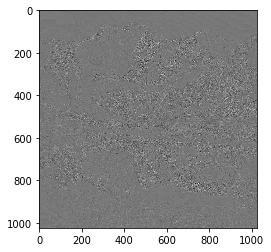

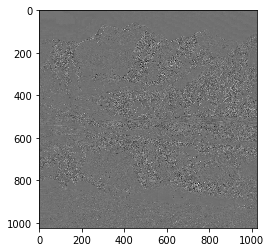

In [16]:
err_X_img = Y_test_img - X_test_img
plt.imshow(err_X_img, cmap='gray')

err_pred_img = Y_test_img - recon
plt.figure()
plt.imshow(err_pred_img, cmap='gray')